## Import e funzioni utili

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import sklearn
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, cohen_kappa_score, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import joblib
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.models import load_model
import xgboost as xgb

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [5]:
local = False

LOCAL_URL = "dropoutData/"
CLOUD_URL = "/content/drive/My Drive/dataset/Dropout/"

base_url = ""

if(local):
  base_url = LOCAL_URL
else:
  base_url = CLOUD_URL


def print_missing_values(dt):
  pd.options.mode.use_inf_as_na = True
  for col in dt.columns:
    na = int(dt[col].isna().sum())
    print("Column '" + col + "' has " + str(na) + " missing values")

def print_columns_len(dt):
  for col in dt.columns:
    print("column '" + col + "' has " + str(len(dt[col])) + " values")

def joblib_save_model(model, filename):
  joblib.dump(model, base_url + filename)

def joblib_load_model(filename):
  return joblib.load(base_url + filename)

def keras_load_model(filename):
  return load_model(base_url + filename)

def print_classification_report_n_mconfusion(y_pred, y_true):
  print(classification_report(y_pred, y_true))
  cm = confusion_matrix(y_test, y_pred) 
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  rocAucScore = roc_auc_score(y_true, y_pred)
  print('> Roc auc score: %.3f' %(rocAucScore))

def SquareErrorDataPoints(_input, _output):
    #input = np.squeeze(_input, axis=0)
    #output = np.squeeze(_output, axis=0)
    # Caculate error
    error = np.square(_input - _output)
    #error = np.sum(error)
    return error

# nr. of standard deviation times the sample is far from the std
def Z_Score(_error):
    mu = np.nanmean(_error)
    gamma = np.nanstd(_error)
    zscore = (_error - mu)/gamma
    return zscore

def CreateLabelBasedOnZscore(_zscore, _threshold, _sign=False):
    label = np.full(_zscore.shape[0], 1)
    if not _sign:
        label[_zscore > _threshold] = -1
        label[_zscore < -_threshold] = -1
    else:
        label[_zscore > _threshold] = -1
    # label[abs(_zscore) > abs(_threshold)] = -1
    return label

def CalculatePrecisionRecallF1Metrics(_abnormal_label, _y_pred):
    precision = precision_score(_abnormal_label, _y_pred)
    recall = recall_score(_abnormal_label, _y_pred)
    f1 = f1_score(_abnormal_label, _y_pred)
    return precision, recall, f1

def CalculateROCAUCMetrics(_abnormal_label, _score):
    fpr, tpr, _ = roc_curve(_abnormal_label, _score)
    roc_auc = auc(np.nan_to_num(fpr), np.nan_to_num(tpr))
    if roc_auc < 0.5:
        roc_auc = 1 - roc_auc
    return fpr, tpr, roc_auc

def CalculatePrecisionRecallCurve(_abnormal_label, _score):
    precision_curve, recall_curve, _ = precision_recall_curve(_abnormal_label, _score)
    average_precision = average_precision_score(_abnormal_label, _score)
    if average_precision < 0.5:
        average_precision = 1 - average_precision
    return precision_curve, recall_curve, average_precision

def PlotROCAUC(_fpr, _tpr, _roc_auc):
    plt.figure(1)
    lw = 1.5
    plt.plot(_fpr, _tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % _roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


def PlotPrecisionRecallCurve(_precision, _recall, _average_precision, _baseline):
    plt.figure(2)
    lw = 2
    plt.step(_recall, _precision, color='darkorange', lw=lw, alpha=1, where='post', label='PR curve (area = %0.2f)' % _average_precision)
    # plt.fill_between(_recall, _precision, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [_baseline, _baseline], color='navy', lw=lw, linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1])
    # plt.legend('AP={0:0.2f}'.format(_average_precision))
    plt.legend(loc="upper right")
    plt.show()

def PlotResult(_values):
    plt.plot(_values)
    plt.show()

# DATA PREPROCESSING

## Acquisizione dati

In [ ]:
if(not local):
  drive.mount('/content/drive')

df = pd.read_excel(base_url + 'stud_2016_2018.xlsx')
df_esami = pd.read_excel(base_url + 'esami_2016_2018.xlsx')
df.head()

## Missing values

FILLING SU VALORI MANCANTI DI voto_scuola_superiore


Per ogni studente senza voto, calcolo la mediana del voto tra l'insieme di studenti che hanno in comune area_geografica_scuola_superiore e Diploma_scuola_superiore

In [ ]:
voto_scuola_superiore_mean = round(df['voto_scuola_superiore'].mean(), 2)

def calculate_mean_vote_with_similar_area_n_diploma(dt, area_scuola, area_residenza, diploma):
    if(diploma == 9):
        return voto_scuola_superiore_mean
    similar_student = dt.loc[(dt['Diploma_scuola_superiore'] == diploma) & ((dt['area_geografica_residenza'] == area_residenza) | (dt['area_geografica_scuolasuperiore'] == area_scuola))]#(dt['area_geografica_residenza'] == area_residenza | dt['area_geografica_scuolasuperiore'] == area_scuola)]
    return round(similar_student['voto_scuola_superiore'].mean(), 2)
    
cacheMap = {"11": 81}

students_without_vote = df.loc[df['voto_scuola_superiore'].isna()]

print(students_without_vote.shape)


for index, row in students_without_vote.iterrows():
    key = str(row.area_geografica_scuolasuperiore) + str(row.Diploma_scuola_superiore)
    if key in cacheMap:
        df.loc[index, 'voto_scuola_superiore'] =  cacheMap[key]
    else:
        median_vote = calculate_mean_vote_with_similar_area_n_diploma(df, row.area_geografica_scuolasuperiore, row.area_geografica_residenza,row.Diploma_scuola_superiore)
        df.loc[index, 'voto_scuola_superiore'] = median_vote
        cacheMap[key] = median_vote

#pd.options.mode.use_inf_as_na = True
print(df['voto_scuola_superiore'].isna().sum())

## Data trasformation

Trasformazioni da effettuare nel dataset:


*   modifica data di nascita in anno di nascita (int64)
*   one hot-econding su (coorte, Diploma_scuola_superiore, area_geografica_scuolasuperiore, area_geografica_residenza)
*   filling su voto_scuola_superiore (utilizzando la mediana dei valori dell'intorno calcolato su area_geografica_scuola_superiore e Diploma_scuola_superiore)
*   filling Merito_ISEE (la classe_ISEE in questo caso agisce come indicatore di reddito famigliare) a questo punto, si
      si potrebbe procedere creando una feature continua, la contribuzione_tasse, che indichi la contribuzione delle tasse,
      quindi tutti gli studenti con classe_ISEE (0, 1) avranno contribuzione_tasse pari a 0. L'implementazione sarà congrua
      con gli scaglioni delle tasse di unibo nel 2016/2017 - 2017/2018 - 2018/2019
*   modifica il tipo di corso con durata_corso -> L: 3, LM: 2, LMCU: 5


A questo punto Classe_ISEE è un buon indicatore del reddito familiare e contribuzione_tasse del contributo pagato

In [ ]:
# ESTRAPOLAZIONE ANNO DI NASCITA - DURATA CORSO - GENERE
def get_year(date):
    return date.year

def get_duration(course_type):
    if(course_type == "L"):
        return 3
    elif(course_type == "LM"):
        return 2
    elif(course_type == "LMCU"):
        return 5
    
def get_genre(genre):
    if(genre == 1):
        return 0
    else:
        return 1

df['AnnoNascita'] = df['DataNascita'].apply(get_year)
df.drop('DataNascita', axis=1, inplace=True)

df['DurataCorso'] = df['TipoCorso'].apply(get_duration)
df.drop('TipoCorso', axis=1, inplace=True)

df['Genere'] = df['Genere'].apply(get_genre)


# FILLING Merito_ISEE
                
def calculate_contribuzione_tasse(dt):
    nrows = dt.shape[0]
    for i in range(nrows):
        current = dt.iloc[i]
        if(current['Coorte'] == 2016):
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 28880.63) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 33371.84) : dt.loc[i, "Contribuzione_tasse"] = 0.6
            elif(current['Merito_ISEE'] <= 38506.71) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 44922.89) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 51337.89) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 51337.90) : dt.loc[i, "Contribuzione_tasse"] = 1
        else:
            if(current['Classe_ISEE'] == 0 or current['Classe_ISEE'] == 1) : dt.loc[i, "Contribuzione_tasse"] = 1
            elif(current['Merito_ISEE'] <= 23000) : dt.loc[i, "Contribuzione_tasse"] = 0
            elif(current['Merito_ISEE'] <= 33000) : dt.loc[i, "Contribuzione_tasse"] = 0.5
            elif(current['Merito_ISEE'] <= 45000) : dt.loc[i, "Contribuzione_tasse"] = 0.7
            elif(current['Merito_ISEE'] <= 60000) : dt.loc[i, "Contribuzione_tasse"] = 0.8
            elif(current['Merito_ISEE'] <= 70000) : dt.loc[i, "Contribuzione_tasse"] = 0.9
            elif(current['Merito_ISEE'] >= 70001) : dt.loc[i, "Contribuzione_tasse"] = 1
                
calculate_contribuzione_tasse(df)
df.drop('Merito_ISEE', axis=1, inplace=True)
df.info()

### One-hot-encode

In [ ]:
def one_hot_encode_n_merge(dt, column, prefix = None):
    name = prefix if prefix is not None else column
    encoded = pd.get_dummies(dt[column], prefix=name)
    return pd.concat([dt, encoded], axis=1)
    
# ONE HOT ENCODING Coorte
df = one_hot_encode_n_merge(df, 'Coorte')
df.drop('Coorte', axis=1, inplace=True)

# ONE HOT ENCODING Diploma_scuola_superiore
df = one_hot_encode_n_merge(df, 'Diploma_scuola_superiore', 'Diploma')
df.drop('Diploma_scuola_superiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_scuolasuperiore
df = one_hot_encode_n_merge(df, 'area_geografica_scuolasuperiore')
df.drop('area_geografica_scuolasuperiore', axis=1, inplace=True)

# ONE HOT ENCODING area_geografica_residenza
df = one_hot_encode_n_merge(df, 'area_geografica_residenza')
df.drop('area_geografica_residenza', axis=1, inplace=True)

# ONE HOT ENCODING CdS
df = one_hot_encode_n_merge(df, 'CdS')
df.drop('CdS', axis=1, inplace=True)

# ONE HOT ENCODING Ambito
df = one_hot_encode_n_merge(df, 'Ambito')
df.drop('Ambito', axis=1, inplace=True)

# DROP Sede
df.drop('Sede', axis=1, inplace=True)

# ONE HOT ENCODING Campus
df = one_hot_encode_n_merge(df, 'Campus')
df.drop('Campus', axis=1, inplace=True)

df.info()

## Aggiunta informazioni degli esami al dataset
Verranno estrapolate le seguenti informazioni per poi essere aggiunte al dataset degli studenti:
- Numero di cfu conseguiti da ogni studente
- Media dei voti degli esami

Ci sono 910 studenti senza media (oltre i 5587 che non hanno neanche cfu conseguiti, che vengono rimossi), si è optato per riempire la colonna della media voti con la media di tutti gli studenti così da non influire statisticamente

In [ ]:
df_esami.info()

In [ ]:
media_voti = df_esami.groupby(['ID_Studente']).mean()['Voto_se_numerico']
cfu_superati = df_esami.groupby(['ID_Studente']).sum()['CFUsuperati']

media_voti = media_voti.fillna(media_voti.mean())

dt = pd.merge(df, media_voti, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = pd.merge(dt, cfu_superati, left_on = 'ID_Studente', right_on = 'ID_Studente', how = 'left')
dt = dt.rename(columns={"Voto_se_numerico": "media_voto", "CFUsuperati": "cfu_superati"})

dt.dropna(subset=['media_voto', 'cfu_superati'], axis=0, inplace=True)

print_missing_values(dt)
print("\n#######################################################\n")
print_columns_len(dt)

## Normalizzazione dati
Scrivi perchè normalizzare e non standardizzare

In [ ]:
mmscaler = MinMaxScaler()

def scale_n_add_to_dt(dataset, column):
  #print(column.shape)]
  toScale = dataset[column].to_numpy().reshape(-1, 1)
  #print(column.shape)
  scaled_column = mmscaler.fit_transform(toScale).squeeze()
  #print(scaled_column.shape)
  dataset.drop(column, axis=1, inplace=True)
  dataset[column] = scaled_column
  #.squeeze()
  return dataset
  #return pd.concat([dataset, pd.Series(scaled_column)], axis=1)

dt = scale_n_add_to_dt(dt, 'voto_scuola_superiore')
dt = scale_n_add_to_dt(dt, 'media_voto')
dt = scale_n_add_to_dt(dt, 'cfu_superati')
dt = scale_n_add_to_dt(dt, 'AnnoNascita')
dt = scale_n_add_to_dt(dt, 'DurataCorso')
dt = scale_n_add_to_dt(dt, 'Classe_ISEE')

print_columns_len(dt)
dt.info()

## Salvataggio su file excel


In [ ]:
dt.to_excel(base_url + 'final_dataset.xlsx')

# DATA ACQUISITION

In [13]:
if(not local):
  drive.mount('/content/drive')

dt = pd.read_excel(base_url + 'final_dataset.xlsx')

dropout_ids = dt.loc[(dt['Abbandoni'] > 0)]["ID_Studente"]

y = dt['Abbandoni']
x = dt.drop('Abbandoni', axis=1)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, stratify=y, test_size=0.15)
print("X train size: " + str(x_train.shape))
print("Y train size: " + str(y_train.shape))
print("X test size: " + str(x_test.shape))
print("Y test size: " + str(y_test.shape))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X train size: (52439, 312)
Y train size: (52439,)
X test size: (9254, 312)
Y test size: (9254,)


# SVM

## Linear SVM

In [ ]:
linear_svm_filename = 'linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = joblib_load_model(linear_svm_filename)
else:
  _svm = svm.SVC(kernel='linear')
  _svm.fit(x_train, y_train)
  joblib_save_model(_svm, linear_svm_filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      9141
           1       0.02      0.08      0.03       113

    accuracy                           0.94      9254
   macro avg       0.50      0.52      0.50      9254
weighted avg       0.98      0.94      0.96      9254



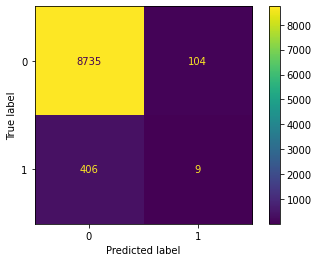

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

## RBF nuSVM

In [ ]:
linear_svm_filename = 'rbf_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = joblib_load_model(linear_svm_filename)
else:
  _svm = NuSVC(nu=0.001)
  _svm.fit(x_train, y_train)
  joblib_save_model(_svm, linear_svm_filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.36      0.96      0.52      3277
           1       0.67      0.05      0.09      5977

    accuracy                           0.37      9254
   macro avg       0.51      0.50      0.30      9254
weighted avg       0.56      0.37      0.24      9254



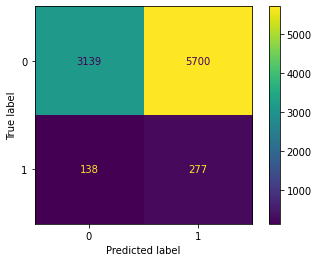

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

## Weighted Class Linear SVM
Viene aumentato il peso della classe 1 (aumentando il focus sulle istanze di tale classe -> ovvero gli abbandoni)

In [14]:
filename = 'weighted_class_linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = joblib_load_model(filename)
else:
  _svm = svm.SVC(kernel='linear', class_weight={1: 10})
  _svm.fit(x_train, y_train)
  joblib_save_model(_svm, filename)

y_predict = _svm.predict(x_test)

### Metriche di performance

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8888
           1       0.05      0.05      0.05       366

    accuracy                           0.92      9254
   macro avg       0.50      0.50      0.50      9254
weighted avg       0.92      0.92      0.92      9254



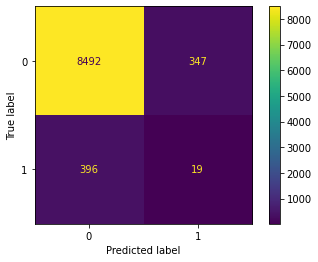

> Roc auc score: 0.503


In [15]:
print_classification_report_n_mconfusion(y_predict, y_test)

## Weighted Samples Linear SVM
Vengono pesate maggiormente le singole istanze (vanno quindi prima trovate)

In [ ]:
sample_weight = np.ones(len(x_train))
for id in dropout_ids:
  try:
    if(x_train.iloc[id - 1] is not None):
      sample_weight[id - 1] = 50
  except:
      pass
    #print("Id: " + str(id) + " not in train test")
    

weighted_samples_linear_svm_filename = 'weighted_samples_linear_svm.sav'
use_pretrained = True

if(use_pretrained):
  _svm = joblib_load_model(weighted_samples_linear_svm_filename)
else:
  _svm = svm.SVC(kernel='linear')
  _svm.fit(x_train, y_train, sample_weight=sample_weight)
  joblib_save_model(_svm, weighted_samples_linear_svm_filename)

y_predict = _svm.predict(x_test)



### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      9131
           1       0.02      0.07      0.03       123

    accuracy                           0.94      9254
   macro avg       0.50      0.51      0.50      9254
weighted avg       0.97      0.94      0.96      9254



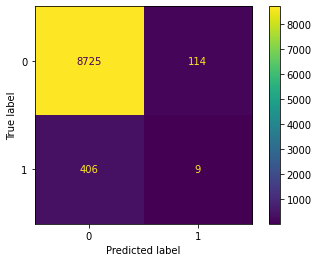

In [ ]:
print_classification_report_n_mconfusion(y_predict, y_test)

# Random Forest

## Random forest with 1000 estimators

In [28]:
filename = 'randomForest_1000.sav'
use_pretrained = True

if(use_pretrained):
  rf = joblib_load_model(filename)
else:
  rf = RandomForestClassifier(n_estimators = 1000, criterion="entropy", n_jobs=-1, verbose=2, random_state = 42, max_features=312)
  rf.fit(x_train, y_train);
  joblib_save_model(rf, filename)

preds = rf.predict(x_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.7s finished


### Metriche di performance

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      9069
           1       0.26      0.59      0.36       185

    accuracy                           0.96      9254
   macro avg       0.63      0.78      0.67      9254
weighted avg       0.98      0.96      0.97      9254



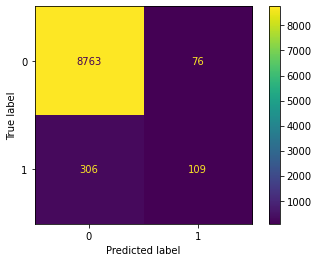

> Roc auc score: 0.627


In [29]:
print_classification_report_n_mconfusion(preds, y_test)

# ANN Basic autoencoder

## Costruzione modello

Per la realizzazione del modello si è scelto di utilizzare la libreria [Keras](https://keras.io/api/), essendo sviluppata logicamente sopra Tensorflow, ovvero Keras utlizza Tensorflow come back-end engine, è di facile utilizzo così da non rendere la curva di apprendimento del framework esageratamente alta ed infine essendo il framework numero uno per quanto riguarda l'ambito machine learning presenta una vasta comunity e un'API ben documentata.

Keras espone un'API di alto livello con cui è possibile costruire reti neurali arbitrariamente complesse senza dover conoscere a fondo i meccanismi di funzionamento e le strutture dati adoperate da Tensorflow.

Il modello è composto da 2 hidden layers composti da 1024 neuroni. Il primo layer ha come funzione di attivazione la funzione ReLU mentre il secondo la funzione sigmoid (sigmoide).

Attraverso la funzione Sequential() si crea un modello in grado di raggruppare una sequenza lineare di layer.
Con il metodo add() si possono aggiungere diversi tipi di layer, in questo caso tutti i layer sono di tipo *Dense* ovvero fortemente connessi con il layer inferiore e superiore.



In [ ]:
input_n_output_dim = x_train.shape[1] #312

# nr. di neuroni nell'encoding layer
encoding_dim = 64
encoding_dim_1 = 128
encoding_dim_2 = 256

# modern way of declaring the model
autoencoder = Sequential()
autoencoder.add(Input(shape=(input_n_output_dim,)))
autoencoder.add(Dense(encoding_dim_2, activation='relu'))
autoencoder.add(Dense(encoding_dim_1, activation='relu'))
#autoencoder.add(Dense(encoding_dim, activation='relu'))
#autoencoder.add(Dense(32, activation='relu'))
#autoencoder.add(Dropout(0.02))
#autoencoder.add(Dense(encoding_dim_1, activation='relu'))
#autoencoder.add(Dropout(0.15))
autoencoder.add(Dense(encoding_dim_2, activation='relu'))
#autoencoder.add(Dropout(0.10))
autoencoder.add(Dense(input_n_output_dim, activation='relu'))

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               80128     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 312)               80184     
                                                                 
Total params: 226,232
Trainable params: 226,232
Non-trainable params: 0
_________________________________________________________________


## Addestramento

Il modello viene addestrato usando come funzione di costo la *mse* (mean squared error) e come ottimizzatore si è scelto di utilizzare Adam (Adaptive moment estimation).
Il numero delle epoche è 30 e come batch size si è scelto 256

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0079)
autoencoder.compile(optimizer=opt, loss='mse') #(adam, RMSprop, Adamax) - mse

Il primo parametro rappresenta l'input del modello mentre il secondo il target, specificando i primi due paramentri (x e y) uguali, si forza il modello a cercare di ricostruire i valori in ingresso.
Viene inoltre specificato un validation_split dell'1% così da poter monitorare la validation loss durante la fase di training

In [ ]:
autoencoder_filename = 'autoencoder.h5'
use_pretrained = True

if(use_pretrained):
  autoencoder = keras_load_model(autoencoder_filename)
else:
  early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
  mc = ModelCheckpoint(base_url + autoencoder_filename, monitor='val_loss', mode='min', save_best_only=True)

  autoencoder.fit(
          x_train,
          x_train,
          epochs = 150,
          batch_size = 1024,
          validation_data = (x_test, x_test),
          callbacks=[early_stop, mc],
  )
  losses = pd.DataFrame(autoencoder.history.history)
  losses[['loss']].plot()
  losses[['loss','val_loss']].plot()



## Validazione modello

In [ ]:
prediction_errors = []

reconstructed = autoencoder.predict(x_test)

mse = np.sum(np.power(x_test - reconstructed, 2), axis=1)
z_scores = Z_Score(mse)

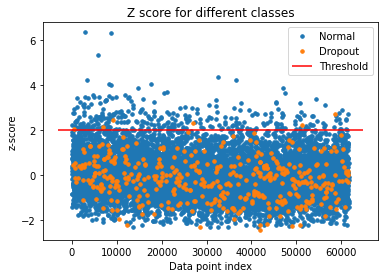

In [ ]:
threshold_fixed = 2
error_df_test = pd.DataFrame({'Z_score': z_scores,
                        'True_class': y_test})
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Z_score, marker='o', ms=3.5, linestyle='',
            label= "Dropout" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Z score for different classes")
plt.ylabel("z-score")
plt.xlabel("Data point index")
plt.show();

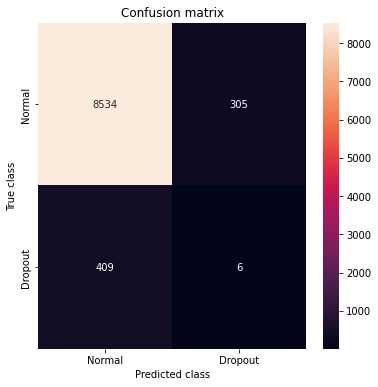

In [ ]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df_test.Z_score.values]
conf_matrix = confusion_matrix(error_df_test.True_class, pred_y)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=["Normal","Dropout"], yticklabels=["Normal", "Dropout"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

<class 'pandas.core.series.Series'>
55283   -1
58454   -1
56729   -1
37978   -1
37330   -1
        ..
20570   -1
9266    -1
8616    -1
24936    1
34332   -1
Name: Abbandoni, Length: 9254, dtype: int64


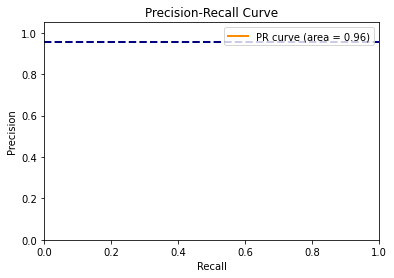

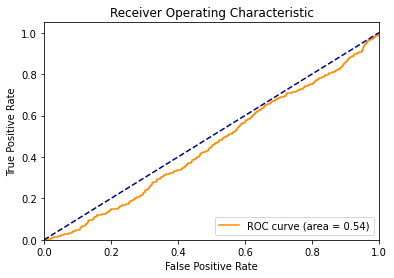

              precision    recall  f1-score   support

          -1       0.97      0.04      0.08      8839
           1       0.05      0.97      0.09       415

    accuracy                           0.08      9254
   macro avg       0.51      0.51      0.08      9254
weighted avg       0.93      0.08      0.08      9254

Precision:  0.045351985559566786


In [ ]:
y_pred = CreateLabelBasedOnZscore(z_scores, threshold_fixed)
s = pd.Series(y_test)
s.replace(0, -1, inplace=True)

precision, recall, f1 = CalculatePrecisionRecallF1Metrics(s, y_pred)
fpr, tpr, roc_auc = CalculateROCAUCMetrics(y_test, z_scores)
precision_curve, recall_curve, average_precision = CalculatePrecisionRecallCurve(y_test, z_scores)
n_normal = np.sum(y_test > 0)
n_dropout = len(y_test) - n_normal
baseline = n_dropout / len(y_test)

PlotPrecisionRecallCurve(precision, recall, average_precision, baseline)
PlotROCAUC(fpr, tpr, roc_auc)
print(classification_report(y_test, y_pred))
print("Precision: ", precision)

# SVM with z scores

In [ ]:
## Z-score for SVM
y_test.replace(-1, 0, inplace=True)
reconstructed_4z = autoencoder.predict(x_train)

mse_4z = np.sum(np.power(x_train - reconstructed_4z, 2), axis=1)
z_scores_4z = Z_Score(mse_4z)

In [ ]:
from sklearn.svm import LinearSVC

linear_svm_zscore_filename = 'linear_svm_zscore.sav'
use_pretrained = False

if(use_pretrained):
  _svmz = joblib_load_model(linear_svm_zscore_filename)
else:
  _svmz = LinearSVC(random_state=0, tol=1e-5)
  #_svmz = svm.SVC(gamma='auto')
  _svmz.fit(np.array(z_scores_4z).reshape(-1, 1), y_train)
  joblib_save_model(_svmz, linear_svm_zscore_filename)

y_predict_z = _svmz.predict(np.array(z_scores).reshape(-1, 1))


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9254
           1       0.00      0.00      0.00         0

    accuracy                           0.96      9254
   macro avg       0.50      0.48      0.49      9254
weighted avg       1.00      0.96      0.98      9254



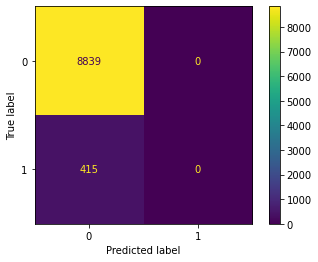

0


In [ ]:
print_classification_report_n_mconfusion(y_predict_z, y_test)
print(y_predict_z[(y_predict_z > 0) == True].size)

# XGBoost

In [ ]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train)

XGBClassifier()

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9145
           1       0.19      0.72      0.30       109

    accuracy                           0.96      9254
   macro avg       0.59      0.84      0.64      9254
weighted avg       0.99      0.96      0.97      9254



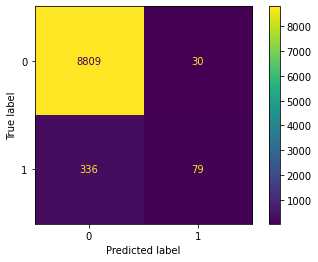

In [ ]:
preds = xgb_cl.predict(x_test)
print_classification_report_n_mconfusion(preds, y_test)

## GridSearchCV

GridSearchCV  è una classe inclusa in Scikit-learn che accetta dei range di possibili valori da testare come hyper-parameter e addestra più modelli su combinazioni dei possibili valori inseriti per determinare la miglior combinazine.

In [ ]:
param_grid = {
    "max_depth": [5, 10],
    "learning_rate": [0.1, 0.05],
    "gamma": [0, 1],
    "reg_lambda": [0, 10],
    "scale_pos_weight": [1, 5],
    "subsample": [0.8],
    "colsample_bytree": [0.5, 0.9],
}

In [ ]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic")

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=3, scoring="roc_auc", verbose=3)

_ = grid_cv.fit(x, y)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [ ]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

0.9268145160217172
{'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'reg_lambda': 10, 'scale_pos_weight': 1, 'subsample': 0.8}


## Modello finale con i best params

In [10]:
best_params = {
    'colsample_bytree': 0.5, 
    'gamma': 0, 
    'learning_rate': 0.1, 
    'max_depth': 5, 
    'reg_lambda': 10, 
    'scale_pos_weight': 1, 
    'subsample': 0.8
 }

final_cl = xgb.XGBClassifier(
    **best_params,
    objective = "binary:logistic"
)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9132
           1       0.19      0.66      0.30       122

    accuracy                           0.96      9254
   macro avg       0.59      0.81      0.64      9254
weighted avg       0.98      0.96      0.97      9254



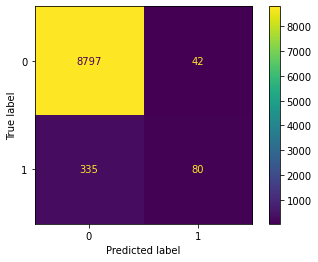

> Roc auc score: 0.594


In [11]:
_ = final_cl.fit(x_train, y_train)

preds = final_cl.predict(x_test)
print_classification_report_n_mconfusion(preds, y_test)

# SMOTE + Random undersampling on XGBoost

In [30]:
# grid search k value for SMOTE oversampling for imbalanced classification
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# values to evaluate
# k_values = [1, 2, 3, 4, 5, 6, 7]
# for k in k_values:
# 1 is the best
# define pipeline
model = final_cl
over = SMOTE(sampling_strategy=0.1, k_neighbors=1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
score = mean(scores)
print('> k=%d, Mean Accuracy: %.3f' %(1, score))

> k=1, Mean Accuracy: 0.927


In [ ]:
print('> Mean Accuracy: %.3f' % (score))

> Mean Accuracy: 0.927


# Just undersampling

In [ ]:
models = [final_cl, rf]
for _model in models:
    model = _model
    under = RandomUnderSampler(sampling_strategy='majority')
    steps = [('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> Mean ROC AUC: %.3f' %(score))


> Mean ROC AUC: 0.926
> Mean ROC AUC: 0.921


# ROBE DA METTERE
1 - visualizzazione "z scores for different classes al variare dell'encoding dell'autoencoder

2 - riportare il fatto che sono stati effettuati svariati test per effettuare l'hyperparameter optimization
# IDEE
1 - usare l'autoencoder come PCA ed usare l'encoder come input di SVM oppure OSVM oppure NN
2 - utilizzare nell'addestramento dell'autoencoder i dati senza dropout
3 - (2 + 1)
4 - Cambia metrica di performance
